# Dynamic Optimization with Uncertainty

In [2]:
import math
import numpy as np
from scipy import stats, optimize
import time
import matplotlib.pyplot as plt

In [3]:
# parameters
alpha = .4
beta = .8
delta = .05
theta_H = 1.2
theta_L = .8
pi_H = .75
pi_L = .65

In [4]:
# utility function
u = lambda c: math.log(c)

In [5]:
# production function
f = lambda k, A: A*k**alpha

In [17]:
# function to calculate distance between two dictionaries with the same indices
def dist(V, W):
    d = 0
    for (_, v), (_, w) in zip(V.items(), W.items()):
        d = d + (v-w)**2
    return math.sqrt(d)

In [9]:
nomes = ['Ana', 'Vitória', 'Elisa', 'Rayne']
numeros = [3, 6, 9]

In [10]:
for nome, num in zip(nomes, numeros):
    print(nome)
    print(num)

Ana
3
Vitória
6
Elisa
9


## Step 1: calculate steady-state

In [11]:
def steadystate(alpha, beta, delta, theta, f):
    k_ss = (theta*alpha*beta/(1-beta*(1-delta)))**(1/(1-alpha))
    c_ss = f(k_ss, 1)-delta*k_ss
    return (k_ss, c_ss)

k_ss_L = steadystate(alpha, beta, delta, theta_L, f)[0]
k_ss_H = steadystate(alpha, beta, delta, theta_H, f)[0]
k_ss = (pi_L*k_ss_L+pi_H*k_ss_H)/(pi_L+pi_H)
c_ss = (pi_L*f(k_ss, theta_L)+pi_H**f(k_ss, theta_H))/(pi_L+pi_H)-delta*k_ss
print("steady-state values:\ncapital: {0:.1f}\nconsumption: {1:.1f}".format(k_ss, c_ss))

steady-state values:
capital: 1.7
consumption: 0.8


## Step 2: define a grid for $k$ (and $k^{\prime}$)

In [12]:
g_size = 1000
kmin = 0
kmax = max([k_ss_H, k_ss_L])*2
step = (kmax-kmin)/g_size

k_grid = np.arange(kmin+step, kmax+step, step)

## Step 3: construct maximizer function

In [13]:
# given a value of k, a state A and a (proposed) value function V,
# find k' that maximizes V over grid of k.  

def maximizer(k, A, V0, u, f, k_grid):
    
    pi = pi_H
    if A == theta_L:
        pi = pi_L
        
    i = 0
    for K in k_grid:
        
        c = f(k, A)+(1-delta)*k-K
        if c>0:
            i += 1
            v = u(c)+beta*(pi*V0[(K,A)]+(1-pi)*V0[(K,2-A)])
            if i == 1:
                vmax = v
                cmax = c
                kmax = K
            elif v>vmax:
                vmax = v
                cmax = c
                kmax = K
                
    return (vmax, cmax, kmax)

## Step 4: define initial value function over grid

In [14]:
# V0 is dictionary. V0(k)=log(k+1)
V0 = {}
for k in k_grid:
    V0[(k, theta_L)] = math.log(k+1)
    V0[(k, theta_H)] = math.log(k+2)

## Step 5: iteration over value function

In [15]:
def bellman(V0, u, f, k_grid, eps=1e-3):
    
    T = {}
    T[0] = (1, 1)
    t0 = time.time()
    d = 1
    i = 0
    
    while d>eps:
        
        V = {}
        C = {}
        K = {}
        
        i += 1
               
        for k in k_grid:
            for A in [theta_L, theta_H]:
                v = maximizer(k, A, V0, u, f, k_grid)
                V[(k, A)] = v[0]
                C[(k, A)] = v[1]
                K[(k, A)] = v[2]
            
        d = abs(dist(V, V0))
        V0 = V
        T[i] = (d, time.time()-t0)
        print('i: {0}, d = {1:.5f} ({2:.2%})'.format(i,d,(d/T[i-1][0])-1))
        
    print('i: {0}, d = {1:.5f})'.format(i,d))
    return (V, C, K, T)

## Shazam!

In [18]:
S = bellman(V0, u, f, k_grid)

i: 1, d = 19.71450 (1871.45%)
i: 2, d = 12.85047 (-34.82%)
i: 3, d = 8.91404 (-30.63%)
i: 4, d = 6.43776 (-27.78%)
i: 5, d = 4.77451 (-25.84%)
i: 6, d = 3.61480 (-24.29%)
i: 7, d = 2.78258 (-23.02%)
i: 8, d = 2.16911 (-22.05%)
i: 9, d = 1.70649 (-21.33%)
i: 10, d = 1.35120 (-20.82%)
i: 11, d = 1.07450 (-20.48%)
i: 12, d = 0.85688 (-20.25%)
i: 13, d = 0.68456 (-20.11%)
i: 14, d = 0.54748 (-20.02%)
i: 15, d = 0.43812 (-19.98%)
i: 16, d = 0.35071 (-19.95%)
i: 17, d = 0.28078 (-19.94%)
i: 18, d = 0.22480 (-19.94%)
i: 19, d = 0.17998 (-19.94%)
i: 20, d = 0.14408 (-19.95%)
i: 21, d = 0.11533 (-19.95%)
i: 22, d = 0.09232 (-19.96%)
i: 23, d = 0.07389 (-19.96%)
i: 24, d = 0.05913 (-19.97%)
i: 25, d = 0.04732 (-19.97%)
i: 26, d = 0.03787 (-19.98%)
i: 27, d = 0.03030 (-19.98%)
i: 28, d = 0.02424 (-19.99%)
i: 29, d = 0.01940 (-19.99%)
i: 30, d = 0.01552 (-19.99%)
i: 31, d = 0.01242 (-19.99%)
i: 32, d = 0.00993 (-19.99%)
i: 33, d = 0.00795 (-19.99%)
i: 34, d = 0.00636 (-20.00%)
i: 35, d = 0.00509 (

## Exploring the results

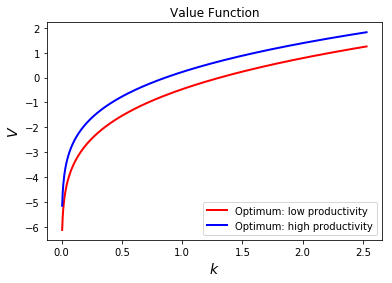

In [12]:
V = S[0]
X = []
Y = []
Z = []

for k in k_grid:
    if k < 1.5*k_ss:
        X.append(k)
        Y.append(V[(k, theta_L)])
        Z.append(V[(k, theta_H)])
        
plt.plot(X, Y, color="red", linewidth=2, label="Optimum: low productivity")
plt.plot(X, Z, color="blue", linewidth=2, label="Optimum: high productivity")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("$V$", fontsize=14)
plt.title("Value Function")
plt.legend(loc='lower right')
plt.show()

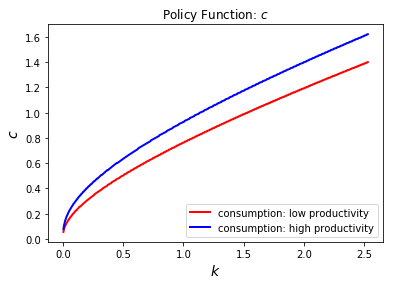

In [13]:
C = S[1]
X = []
Y = []
Z = []
for k in k_grid:
    if k < 1.5*k_ss:
        X.append(k)
        Y.append(C[(k, theta_L)])
        Z.append(C[(k, theta_H)])

plt.plot(X, Y, color="red", linewidth=2, label="consumption: low productivity")
plt.plot(X, Z, color="blue", linewidth=2, label="consumption: high productivity")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("$c$", fontsize=14)
plt.title("Policy Function: $c$")
plt.legend(loc='lower right')
plt.show()

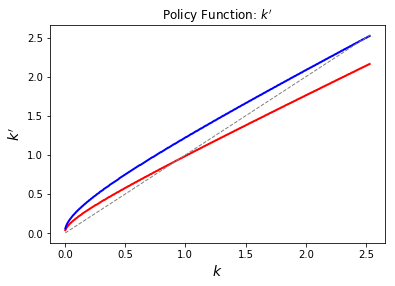

In [14]:
K = S[2]
X = []
Y = []
Z = []
W = []

for k in k_grid:
    if k < 1.5*k_ss:
        X.append(k)
        Y.append(K[(k, theta_L)])
        Z.append(K[(k, theta_H)])
        W.append(k)

plt.plot(X, Y, color="red", linewidth=2)
plt.plot(X, Z, color="blue", linewidth=2)
plt.plot(X, W, '--', color="gray", linewidth=1)
plt.xlabel("$k$", fontsize=14)
plt.ylabel("$k^{\prime}$", fontsize=14)
plt.title("Policy Function: $k^{\prime}$")
plt.show()

## Simulation

In [15]:
def shox(A, pi_H, pi_L, theta_H, theta_L):
    
    if A == 1.5:
        pi = pi_H
    else:
        pi = pi_L
    
    x = np.random.binomial(1,pi_H)
    
    return A*x+(2-A)*(1-x)

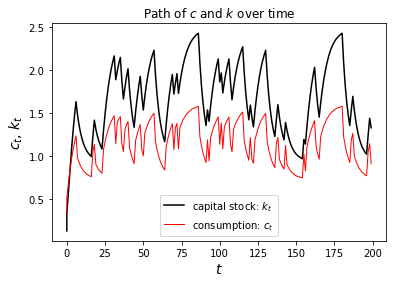

In [16]:
np.random.seed(1910)
C = S[1]
K = S[2]

k0 = k_grid[30]
a0 = theta_H
n = 200

X = [k0]
Y = [C[(k0, a0)]]
A = [a0]
T = [0]

s = 0
for t in np.arange(0,n):
    T.append(t)
    a0 = shox(a0, pi_H, pi_L, theta_H, theta_L)
    A.append(a0)
    k = K[(k0, a0)]
    X.append(k)
    c = C[(k, a0)]
    Y.append(c)
    k0 = k
    
plt.plot(T, X, color="black", linewidth=1.5, label="capital stock: $k_{t}$")
plt.plot(T, Y, color="red", linewidth=1, label="consumption: $c_{t}$")
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$c_{t}$, $k_{t}$", fontsize=14)
plt.title("Path of $c$ and $k$ over time")
plt.legend(loc="lower center")
plt.show()

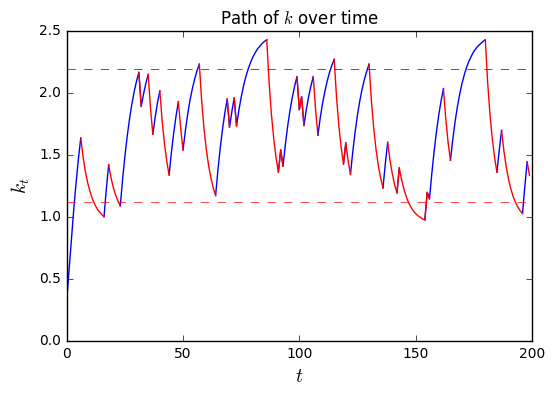

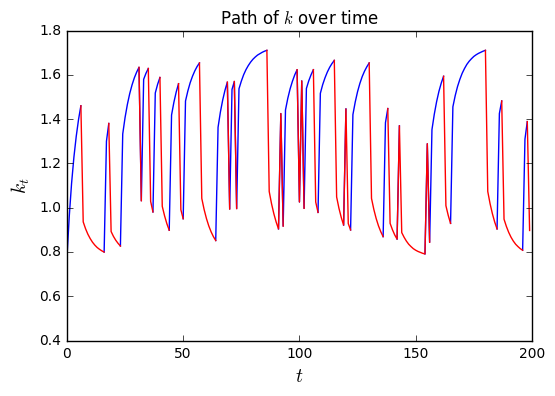

In [164]:
import numpy.ma as ma

mask_H = []
mask_L = []
K_H = []
K_L = []
B = list(A)
B.append(B[n])

Y = []

for i, a in enumerate(A):
    
    b = B[i+1]
    
    if a == theta_H and b == theta_H:
        mask_H.append(0)
        mask_L.append(1)
    elif a == theta_L and b == theta_L:
        mask_H.append(1)
        mask_L.append(0)
    elif a != b:
        mask_H.append(0)
        mask_L.append(0)
        
    K_H.append(k_ss_H)
    K_L.append(k_ss_L)
    Y.append(f(X[i], a))

X_H = ma.masked_array(X, mask=mask_H)
X_L = ma.masked_array(X, mask=mask_L)

Y_H = ma.masked_array(Y, mask=mask_H)
Y_L = ma.masked_array(Y, mask=mask_L)

plt.plot(T, X_H, color="blue", lw=1)
plt.plot(T, X_L, color="red", lw=1)
plt.plot(T, K_H, '--', color="blue", lw=.5)
plt.plot(T, K_L, '--', color="red", lw=.5)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$k_{t}$", fontsize=14)
plt.title("Path of $k$ over time")
plt.show()

plt.plot(T, Y_H, color="blue", lw=1)
plt.plot(T, Y_L, color="red", lw=1)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$k_{t}$", fontsize=14)
plt.title("Path of $k$ over time")
plt.show()